/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)



=== Data Loaded from S3 (Parquet) ===
Columns: ['date', 'primary type', 'location description', 'Arrest', 'Domestic', 'community area', 'latitude', 'longitude', 'year', 'month', 'day', 'hour']
                  date       primary type  \
0  2023-09-06 11:00:00              THEFT   
1  2022-01-14 15:55:00      OTHER OFFENSE   
2  2022-08-05 21:00:00        SEX OFFENSE   
3  2022-08-14 14:00:00        SEX OFFENSE   
4  2022-11-10 03:47:00  WEAPONS VIOLATION   

                     location description  Arrest  Domestic  community area  \
0  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False            32.0   
1                               RESIDENCE   False      True            68.0   
2                               APARTMENT    True     False            69.0   
3                               RESIDENCE   False     False            11.0   
4                                  STREET   False     False            68.0   

    latitude  longitude  year  month  day  hour  
0  41.8718

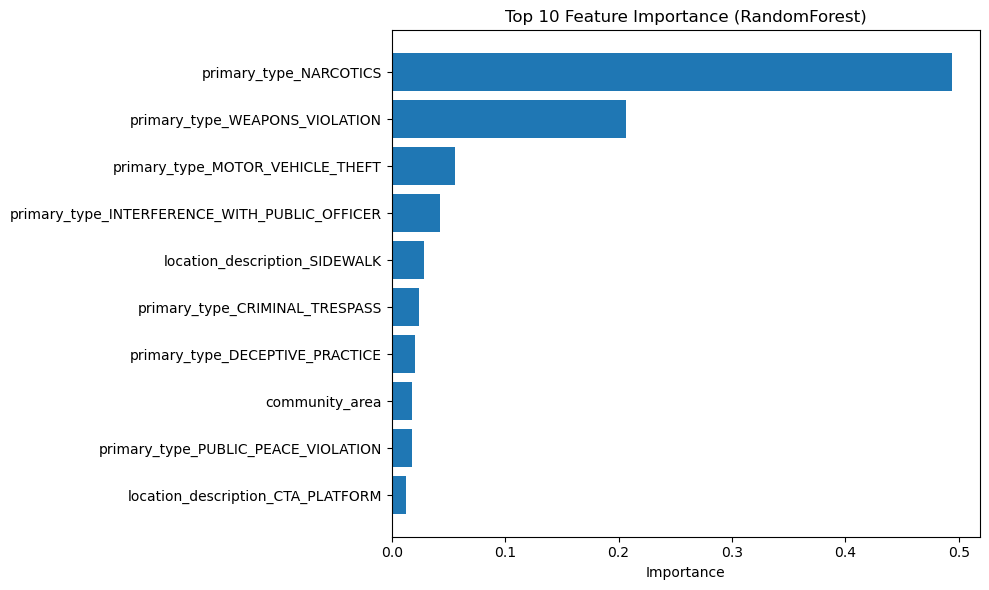


=== Uploaded crime_prediction_model.joblib to S3 ===

=== Training Multiple Models (Comparison) ===


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:25:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 41143, number of negative: 305234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 346377, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118781 -> initscore=-2.004025
[LightGBM] [Info] Start training from score -2.004025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:25:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 41143, number of negative: 305234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 346377, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118781 -> initscore=-2.004025
[LightGBM] [Info] Start training from score -2.004025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Figure size 1200x600 with 0 Axes>

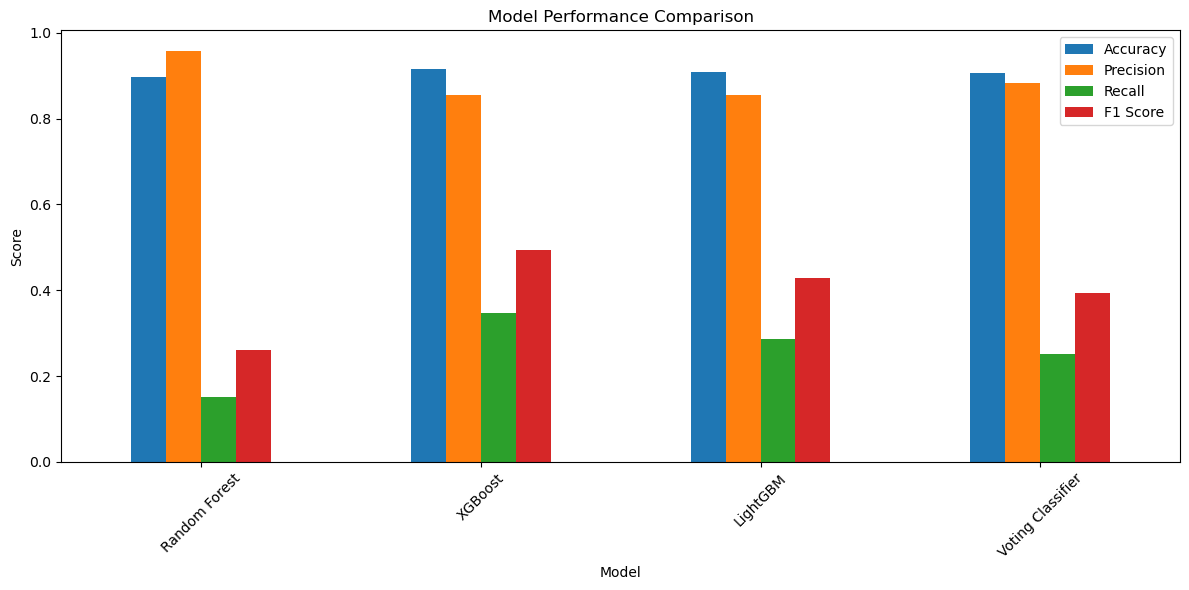


Best Model (by F1 Score): XGBoost
=== Uploaded best_crime_prediction_model.joblib to S3 ===

=== Quick Demo of Predictions ===
   Actual  Predicted  Probability_of_Arrest
0   False      False               0.095526
1   False      False               0.069570
2   False      False               0.100743
3   False      False               0.104017
4   False      False               0.300931

Available columns after renaming & encoding: ['date', 'primary_type', 'location_description', 'arrest', 'domestic', 'community_area', 'latitude', 'longitude', 'year', 'month', 'day', 'hour']

=== Crime Type Distribution ===


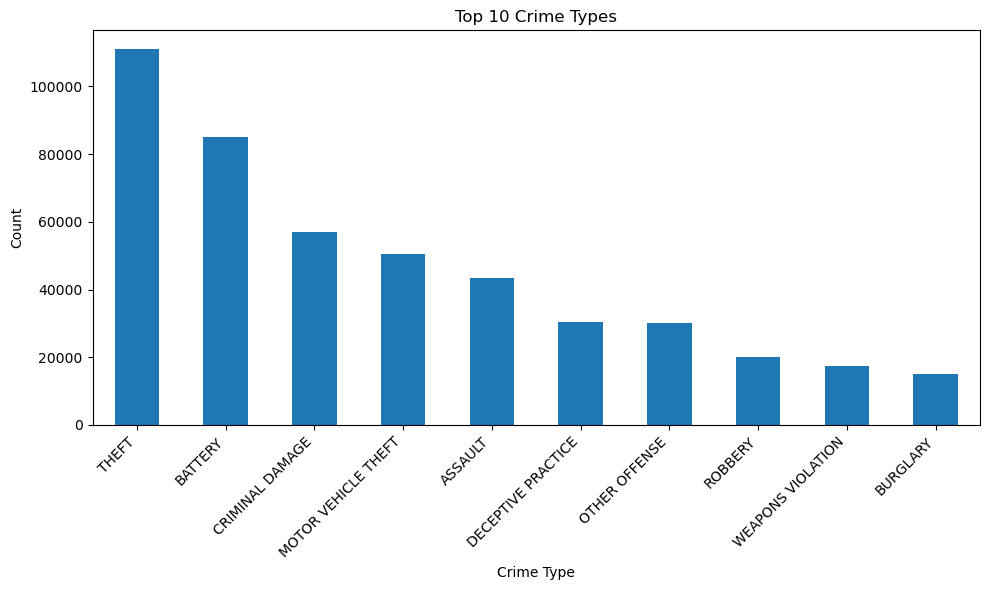


=== Arrest Rate by Crime Type ===


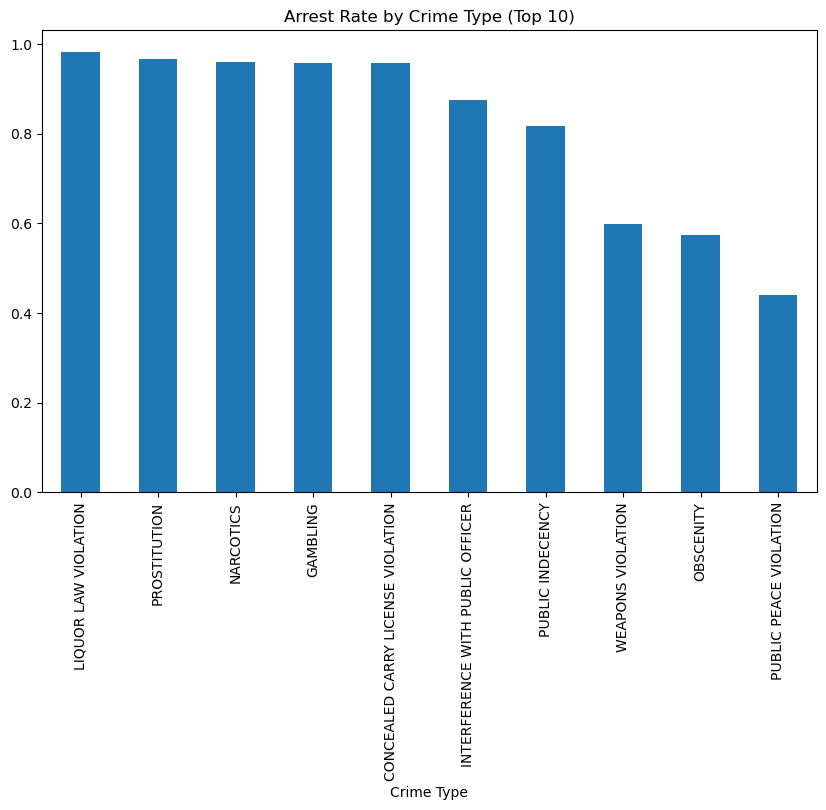

In [1]:
##################################################
# 1) Imports
##################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import joblib

# Scikit-learn & LightGBM/XGBoost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

##################################################
# 2) S3 + Parquet Data Ingestion
##################################################
s3_client = boto3.client('s3')
bucket = 'crime-analytics-final'  # <-- Replace if needed
key = 'processed-data/part-00000-b8ff1314-c157-424b-ac91-dd81c410c031-c000.snappy.parquet'
# Reading Parquet directly from S3
crime_df = pd.read_parquet(f's3://{bucket}/{key}')

print("\n=== Data Loaded from S3 (Parquet) ===")
print("Columns:", crime_df.columns.tolist())
print(crime_df.head())

##################################################
# 3) Handle Column Naming & Identify Date Column
##################################################
# Convert all column names to lowercase and replace spaces with underscores
crime_df.columns = crime_df.columns.str.lower().str.replace(' ', '_')

# Attempt to detect a date/time column
date_column = None
for col in crime_df.columns:
    # Look for 'date' or 'time' in the column name
    if 'date' in col or 'time' in col:
        date_column = col
        print(f"Identified date/time column: {date_column}")
        break

##################################################
# 4) Prepare Features (X) and Target (y)
##################################################
# We assume 'arrest' is the target column
drop_cols = ['arrest']
if date_column:
    drop_cols.append(date_column)

# Drop these columns from features
X = crime_df.drop(columns=drop_cols, errors='ignore')
y = crime_df['arrest']  # Target

##################################################
# 5) Encode Categorical Features & Clean Column Names
##################################################
# 5a) One-Hot Encode
X = pd.get_dummies(X)

# 5b) Remove/replace any special characters that LightGBM doesn't accept
X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

print("\n=== After One-Hot Encoding & Column Cleanup ===")
print("Feature columns:", X.columns.tolist())

##################################################
# 6) Split Data for Training/Testing
##################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42
)

##################################################
# 7) Simple RandomForest Model for Starter
##################################################
rf_demo_model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
rf_demo_model.fit(X_train, y_train)
rf_demo_pred = rf_demo_model.predict(X_test)

acc = accuracy_score(y_test, rf_demo_pred)
prec = precision_score(y_test, rf_demo_pred)
rec = recall_score(y_test, rf_demo_pred)
f1 = f1_score(y_test, rf_demo_pred)

print("\n=== RandomForest (Demo) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

##################################################
# 8) Feature Importance (Demo Model)
##################################################
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_demo_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (RandomForest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##################################################
# 9) Save Demo Model & Upload to S3
##################################################
joblib.dump(rf_demo_model, 'crime_prediction_model.joblib')
s3_client.upload_file(
    'crime_prediction_model.joblib',
    bucket,
    'model-artifacts/crime_prediction_model.joblib'
)
print("\n=== Uploaded crime_prediction_model.joblib to S3 ===")

##################################################
# 10) Train Multiple Models: RF, XGB, LightGBM
##################################################
print("\n=== Training Multiple Models (Comparison) ===")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# LightGBM
lgbm_model = LGBMClassifier(n_estimators=10, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

##################################################
# 11) Voting Classifier
##################################################
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft'
)
voting_model.fit(X_train, y_train)
voting_pred = voting_model.predict(X_test)

##################################################
# 12) Evaluate Model Performance
##################################################
models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred,
    'Voting Classifier': voting_pred
}

results = {}
for name, pred in models.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

comparison_df = pd.DataFrame(results).T
print("\n=== Model Comparison ===")
print(comparison_df)

##################################################
# 13) Visualize Model Comparison
##################################################
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##################################################
# 14) Select & Save Best Model
##################################################
best_model_name = comparison_df['F1 Score'].idxmax()
print(f"\nBest Model (by F1 Score): {best_model_name}")

if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'LightGBM':
    best_model = lgbm_model
else:
    best_model = voting_model

joblib.dump(best_model, 'best_crime_prediction_model.joblib')

# Upload best model to S3
s3_client.upload_file(
    'best_crime_prediction_model.joblib',
    bucket,
    'model-artifacts/best_crime_prediction_model.joblib'
)
print("=== Uploaded best_crime_prediction_model.joblib to S3 ===")

##################################################
# 15) Quick Demo of Predictions
##################################################
print("\n=== Quick Demo of Predictions ===")
loaded_model = joblib.load('crime_prediction_model.joblib')  # or best_crime_prediction_model.joblib

sample_input = X_test.iloc[0:5]
sample_predictions = loaded_model.predict(sample_input)
sample_probabilities = loaded_model.predict_proba(sample_input)[:, 1]

demo_results = pd.DataFrame({
    'Actual': y_test.iloc[0:5].values,
    'Predicted': sample_predictions,
    'Probability_of_Arrest': sample_probabilities
})
print(demo_results)

##################################################
# 16) Additional Visualizations
##################################################
print("\nAvailable columns after renaming & encoding:", crime_df.columns.tolist())

# If 'primary_type' in your data
if 'primary_type' in crime_df.columns:
    print("\n=== Crime Type Distribution ===")
    plt.figure(figsize=(10, 6))
    crime_df['primary_type'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Crime Types')
    plt.xlabel('Crime Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\n=== Arrest Rate by Crime Type ===")
    arrest_by_type = crime_df.groupby('primary_type')['arrest'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    arrest_by_type.head(10).plot(kind='bar')
    plt.title('Arrest Rate by Crime Type (Top 10)')
    plt.xlabel('Crime Type')
    plt
